In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import collections
import itertools
from math import sqrt

tf.logging.set_verbosity(tf.logging.INFO)
%matplotlib inline

plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams.update({'font.size': 22})

In [2]:
# Functions

# Load Dataset
def load_data(output_path, window_size, compute_RR_interval_feature):
    extension = '_' + str(window_size)
    if compute_RR_interval_feature:
        extension = extension + '_' + 'RR'
        extension = extension + '.csv'

    # Load training and eval data
    train_data = np.loadtxt(output_path + 'train_data' + extension, delimiter=",", dtype=float)
    train_labels =  np.loadtxt(output_path + 'train_label' + extension, delimiter=",",  dtype=np.int32)
    eval_data = np.loadtxt(output_path + 'eval_data' + extension, delimiter=",", dtype=float)
    eval_labels = np.loadtxt(output_path + 'eval_label' + extension, delimiter=",",  dtype=np.int32)

    return (train_data, train_labels, eval_data, eval_labels)

# Normalize data features
def normalize_data(train_data, eval_data):
    feature_size = len(train_data[0])

    max_wav = np.amax(np.vstack((train_data[:, 0:feature_size], eval_data[:, 0:feature_size])))
    min_wav = np.amin(np.vstack((train_data[:, 0:feature_size], eval_data[:, 0:feature_size])))

    train_data[:, 0:feature_size] = ((train_data[:,0:feature_size] - min_wav) / (max_wav - min_wav))
    eval_data[:, 0:feature_size] = ((eval_data[:,0:feature_size] - min_wav) / (max_wav - min_wav))

    return (train_data, eval_data)

# Train Inputs
def get_train_inputs():
    x = tf.constant(train_data)
    y = tf.constant(train_labels)
    return x, y

# Test Inputs
def get_test_inputs():
    x = tf.constant(eval_data)
    y = tf.constant(eval_labels)
    return x, y

# Eval data
def get_eval_data():
    return np.array(eval_data, dtype=np.float32)

# Plot matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

=======INPUT=======
Counter({1: 3946, 2: 3778, 4: 3674, 0: 2890, 3: 803})
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002B231D57940>, '_save_checkpoints_secs': 600, '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_train_distribute': None, '_is_chief': True, '_tf_random_seed': None, '_num_ps_replicas': 0, '_environment': 'local', '_task_id': 0, '_num_worker_replicas': 0, '_evaluation_master': '', '_session_config': None, '_model_dir': 'C:\\Users\\soma06\\AppData\\Local\\Temp\\tmprnwt0gk7', '_keep_checkpoint_every_n_hours': 10000, '_task_type': No

C:\Program Files\Anaconda3\envs\signalus\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Program Files\Anaconda3\envs\signalus\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix


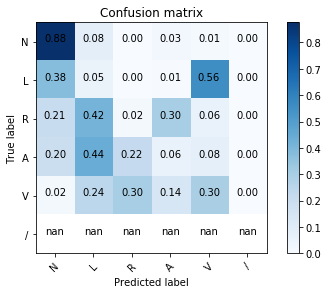

In [3]:
window_size = 160
compute_RR_interval_feature = True
steps = 10000
layers = [20,30,30,20]
dataset = 'mit_db/'
output_path = 'trainedDataSet/'
weight_imbalanced = True
all_class_names = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'P', '/', 'f', 'u']
class_names= ['N', 'L', 'R', 'A', 'V', '/']


# Load Data
train_data, train_labels, eval_data, eval_labels = load_data(output_path, window_size, compute_RR_interval_feature)

# Preprocess data. Normalize. if RR interval, last 4 features are pre, post, local and global RR
train_data, eval_data =  normalize_data(train_data, eval_data)

# Create my own model
LEARNING_RATE = 0.001 # Learning rate for the model
num_classes = len(class_names) # Output Classes
weights = np.random.randn(len(train_labels)) / sqrt(len(train_labels) / 2) # He’s initialization

# Set model params
count = collections.Counter(train_labels)
print("=======INPUT=======")
print(count)

# Specify that all features have real-value data
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=len(train_data[0]))]

# Build 3 layer DNN with 10, 20, 10 units respectively.
classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                        hidden_units=layers, # TODO
                                        n_classes=num_classes)
                                        # optimizer is one of 'Adagrad', 'Adam', 'Ftrl', 'RMSProp', 'SGD'

# Fit model.
classifier.fit(input_fn=get_train_inputs, steps=steps) # TODO

# Evaluate accuracy. 
accuracy_score = classifier.evaluate(input_fn=get_test_inputs, steps=1)["accuracy"]
print("\nTest Accuracy: {0:f}\n".format(accuracy_score))

predictions = classifier.predict(input_fn=get_eval_data, as_iterable=False)

# Compute the matrix confussion
confusion_matrix = np.zeros((num_classes,num_classes), dtype='int')

for p in range(0, len(predictions)):
    confusion_matrix[predictions[p]][eval_labels[p]] = confusion_matrix[predictions[p]][eval_labels[p]] + 1
                                     
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True,
                    title='Confusion matrix')
plt.show()